#Data used:
I have chosen a dataset which describes the number of daily female births in California in 1959 which contains 365 entries.

Link — https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv

In [53]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array#a.) convert time series into supervised learning problem

from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot as plt
from numpy import array


def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 n_vars = 1 if type(data) is list else data.shape[1]
 df = DataFrame(data)
 cols, names = list(), list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
  cols.append(df.shift(i))
  names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
  cols.append(df.shift(-i))
  if i == 0:
   names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
  else:
   names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
 # put it all together
 agg = concat(cols, axis=1)
 agg.columns = names
 # drop rows with NaN values
 if dropnan:
  agg.dropna(inplace=True)
 return agg
 
#b.) create a differenced series
def difference(dataset, interval=1):
 diff = list()
 for i in range(interval, len(dataset)):
  value = dataset[i] - dataset[i - interval]
  diff.append(value)
 return Series(diff)
 
#c.) transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
 # extract raw values
 raw_values = series.values
 # transform data to be stationary
 diff_series = difference(raw_values, 1)
 diff_values = diff_series.values
 diff_values = diff_values.reshape(len(diff_values), 1)
 # rescale values to -1, 1
 scaler = MinMaxScaler(feature_range=(-1, 1))
 scaled_values = scaler.fit_transform(diff_values)
 scaled_values = scaled_values.reshape(len(scaled_values), 1)
 # transform into supervised learning problem X, y
 supervised = series_to_supervised(scaled_values, n_lag, n_seq)
 supervised_values = supervised.values
 # split into train and test sets
 train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
 return scaler, train, test
 
#d.) Define the LSTM network 
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
  # reshape training into [samples, timesteps, features]
  X, y = train[:, 0:n_lag], train[:, n_lag:]
  X = X.reshape(X.shape[0], 1, X.shape[1])
  # design network
  model = Sequential()
  model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
  model.add(Dense(y.shape[1]))
  model.compile(loss='mean_squared_error', optimizer='adam')
  # # fit network
  # for i in range(nb_epoch):
    # model.fit(X, y, epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
    # model.reset_states()
  # return model
  history_loss=[]
  history_val_loss=[]
  for i in range(nb_epoch):
      print(i)
      hist = model.fit(X, y, validation_split=0.1,epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
      history_loss.append(hist.history['loss'])
      history_val_loss.append(hist.history['val_loss'])
  print(model.summary())
  return model,history_loss,history_val_loss
 
#e.) forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
 # reshape input pattern to [samples, timesteps, features]
 X = X.reshape(1, 1, len(X))
 # make forecast
 forecast = model.predict(X, batch_size=n_batch)
 # convert to array
 return [x for x in forecast[0, :]]
 
#f.)  evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
 forecasts = list()
 for i in range(len(test)):
  X, y = test[i, 0:n_lag], test[i, n_lag:]
  # make forecast
  forecast = forecast_lstm(model, X, n_batch)
  # store the forecast
  forecasts.append(forecast)
 return forecasts
 
#g.) invert differenced forecast
def inverse_difference(last_ob, forecast):
 # invert first forecast
 inverted = list()
 inverted.append(forecast[0] + last_ob)
 # propagate difference forecast using inverted first value
 for i in range(1, len(forecast)):
  inverted.append(forecast[i] + inverted[i-1])
 return inverted
 
#h.) inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
 inverted = list()
 for i in range(len(forecasts)):
  # create array from forecast
  forecast = array(forecasts[i])
  forecast = forecast.reshape(1, len(forecast))
  # invert scaling
  inv_scale = scaler.inverse_transform(forecast)
  inv_scale = inv_scale[0, :]
  # invert differencing
  index = len(series) - n_test + i - 1
  last_ob = series.values[index]
  inv_diff = inverse_difference(last_ob, inv_scale)
  # store
  inverted.append(inv_diff)
 return inverted
 
#i.) evaluate the model with RMSE 
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
 for i in range(n_seq):
  actual = [row[i] for row in test]
  predicted = [forecast[i] for forecast in forecasts]
  rmse = sqrt(mean_squared_error(actual, predicted))
  print('t+%d RMSE: %f' % ((i+1), rmse))
 
#j.) plot the forecasts
def plot_forecasts(series, forecasts, n_test):
 # plot the entire dataset in blue
 pyplot.plot(series.values)
 # plot the forecasts in red
 for i in range(len(forecasts)):
  off_s = len(series) - n_test + i - 1
  off_e = off_s + len(forecasts[i]) + 1
  xaxis = [x for x in range(off_s, off_e)]
  yaxis = [series.values[off_s]] + forecasts[i]
  pyplot.plot(xaxis, yaxis, color='red')
 # show the plot
 pyplot.show()# load the dataset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


In [33]:
series = read_csv('/content/daily-total-female-births.csv',
                  usecols=[0, 1], index_col=['Date'], encoding='cp1251',
                  parse_dates=['Date'])
series

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44
...,...
1959-12-27,37
1959-12-28,52
1959-12-29,48


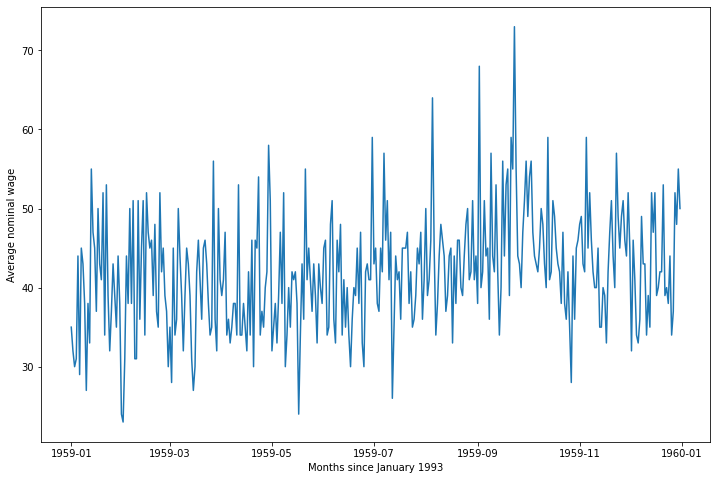

In [34]:
plt.figure(figsize=(12,8))
plt.plot(series)
plt.ylabel('Average nominal wage')
plt.xlabel('Months since January 1993')
plt.show()

In [35]:
# trajectory matrix

d1 = series_to_supervised(series, n_in=5, n_out=7, dropnan=True)
d1

,var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
Date,,,,,,,,,,,,
1959-01-06,35.0,32.0,30.0,31.0,44.0,29,45.0,43.0,38.0,27.0,38.0,33.0
1959-01-07,32.0,30.0,31.0,44.0,29.0,45,43.0,38.0,27.0,38.0,33.0,55.0
1959-01-08,30.0,31.0,44.0,29.0,45.0,43,38.0,27.0,38.0,33.0,55.0,47.0
1959-01-09,31.0,44.0,29.0,45.0,43.0,38,27.0,38.0,33.0,55.0,47.0,45.0
1959-01-10,44.0,29.0,45.0,43.0,38.0,27,38.0,33.0,55.0,47.0,45.0,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1959-12-21,52.0,39.0,40.0,42.0,42.0,53,39.0,40.0,38.0,44.0,34.0,37.0
1959-12-22,39.0,40.0,42.0,42.0,53.0,39,40.0,38.0,44.0,34.0,37.0,52.0
1959-12-23,40.0,42.0,42.0,53.0,39.0,40,38.0,44.0,34.0,37.0,52.0,48.0


In [65]:
series

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44
...,...
1959-12-27,37
1959-12-28,52
1959-12-29,48


In [64]:
n_lag = 36
n_seq = 36
n_test = 1
n_epochs = 30
n_batch = 1
n_neurons =  32

scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)

In [55]:
# hyperparameters initialization and training the model
model,history_loss,history_val_loss = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)

forecasts = inverse_transform(series, forecasts, scaler, n_test+2)

0
262/262 [==============================] - 2s 3ms/step - loss: 0.0998 - val_loss: 0.0712
1
262/262 [==============================] - 0s 2ms/step - loss: 0.0974 - val_loss: 0.0712
2
262/262 [==============================] - 1s 2ms/step - loss: 0.0959 - val_loss: 0.0715
3
262/262 [==============================] - 0s 2ms/step - loss: 0.0945 - val_loss: 0.0720
4
262/262 [==============================] - 0s 2ms/step - loss: 0.0932 - val_loss: 0.0725
5
262/262 [==============================] - 0s 2ms/step - loss: 0.0918 - val_loss: 0.0732
6
262/262 [==============================] - 1s 2ms/step - loss: 0.0904 - val_loss: 0.0740
7
262/262 [==============================] - 1s 2ms/step - loss: 0.0890 - val_loss: 0.0748
8
262/262 [==============================] - 0s 2ms/step - loss: 0.0875 - val_loss: 0.0755
9
262/262 [==============================] - 0s 2ms/step - loss: 0.0860 - val_loss: 0.0763
10
262/262 [==============================] - 1s 2ms/step - loss: 0.0845 - val_loss: 0.077

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


epoch:0
epoch:100
epoch:200
epoch:300
epoch:400
epoch:500
epoch:600
epoch:700
epoch:800
epoch:900
Month=1, Predicted=42.584791, Expected=42.000000
Month=2, Predicted=41.321367, Expected=53.000000
Month=3, Predicted=43.793316, Expected=39.000000
Month=4, Predicted=42.311569, Expected=40.000000
Month=5, Predicted=42.078022, Expected=38.000000
Month=6, Predicted=40.521849, Expected=44.000000
Month=7, Predicted=39.913746, Expected=34.000000
Month=8, Predicted=38.637127, Expected=37.000000
Month=9, Predicted=40.061481, Expected=52.000000
Month=10, Predicted=41.826616, Expected=48.000000
Month=11, Predicted=48.606757, Expected=55.000000
Month=12, Predicted=48.031407, Expected=50.000000
Test RMSE: 6.170


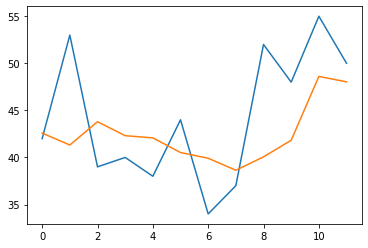

In [36]:
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
 

history_loss=[]
history_val_loss=[]

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
  X, y = train[:, 0:-1], train[:, -1]
  X = X.reshape(X.shape[0], 1, X.shape[1])
  model = Sequential()
  model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  
  for i in range(nb_epoch):
    hist = model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    history_loss.append(hist.history['loss'])
    history_val_loss.append(hist.history['val_loss'])
    if i%100 == 0:
      print("epoch:{}".format(i))
    model.reset_states()
  return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
 
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 1000, 128)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)
 
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
 
# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()

In [81]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error

### Evaluation Metrics for LSTM

In [37]:
mape = mean_absolute_percentage_error(raw_values[-12:], predictions)
r2score = r2_score(raw_values[-12:], predictions)
print('MAPE: %f' % (mape))
print('R2 score: %f' % (r2score))

MAPE: 0.111111
R2 score: 0.164354


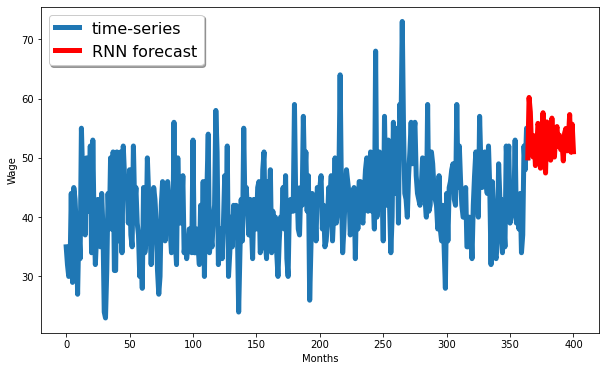

In [56]:
# visualize
data = series
fig=plt.figure(figsize=(10,6))
plt.plot(data.values[:],linewidth=5)
off_s = len(data) - n_test +len(forecasts)  - 1
off_e = off_s + len(forecasts[0]) + 1
xaxis = [x for x in range(off_s, off_e)]
yaxis = [data.values[off_s]] + forecasts[-1]
plt.plot(xaxis, yaxis, color='r',linewidth=5)

plt.ylabel('Wage')
plt.xlabel('Months')

plt.legend(('time-series', 'RNN forecast'),
           shadow=True, loc='upper left', handlelength=1.5, fontsize=16)
plt.show()

In [146]:
# Loss functions for val and train sets

plt.plot(history_loss, 'r',label='train')
plt.plot(history_val_loss,label='validation')
plt.legend()
print(history_loss[-1],history_val_loss[-1])

## ARIMA model forecast

In [82]:

# let's import necassary packages...

%pylab inline
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['sqrt', 'test', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [83]:
series.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


In [84]:
series.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 1959-01-01 to 1959-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Births  365 non-null    int64
dtypes: int64(1)
memory usage: 5.7 KB


In [85]:
series.index

DatetimeIndex(['1959-01-01', '1959-01-02', '1959-01-03', '1959-01-04',
               '1959-01-05', '1959-01-06', '1959-01-07', '1959-01-08',
               '1959-01-09', '1959-01-10',
               ...
               '1959-12-22', '1959-12-23', '1959-12-24', '1959-12-25',
               '1959-12-26', '1959-12-27', '1959-12-28', '1959-12-29',
               '1959-12-30', '1959-12-31'],
              dtype='datetime64[ns]', name='Date', length=365, freq=None)

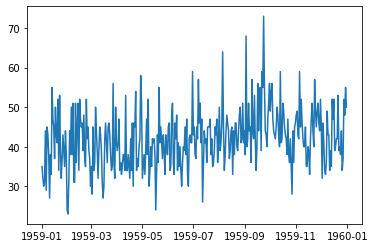

In [86]:
plt.plot(series)
plt.show()

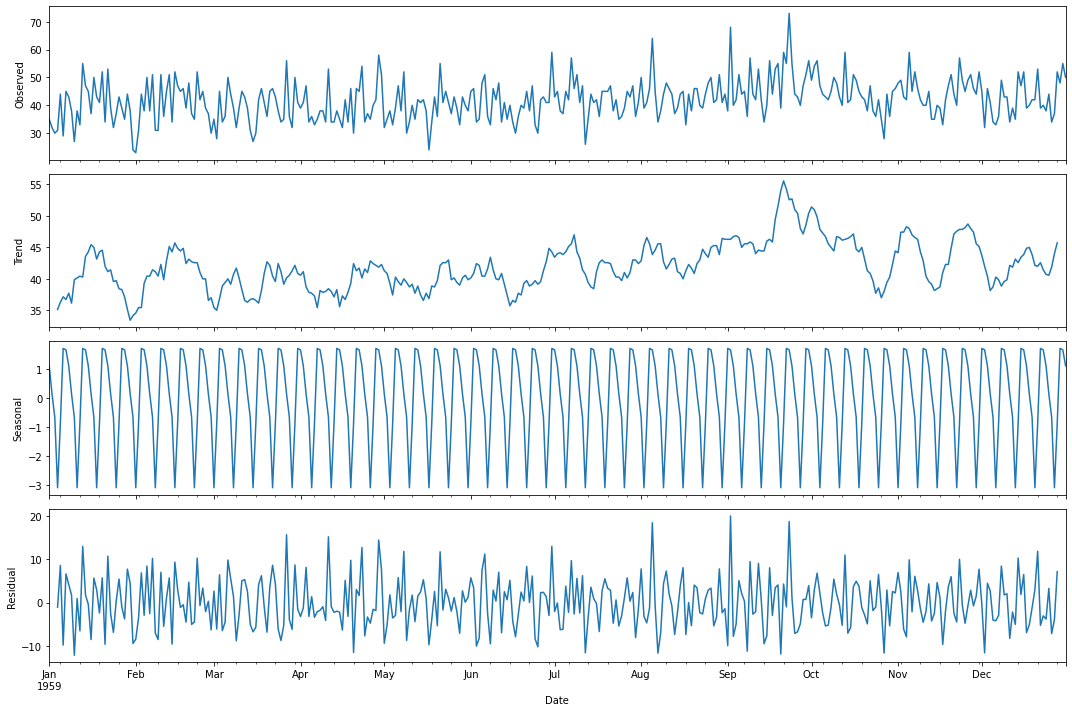

<Figure size 1080x720 with 0 Axes>

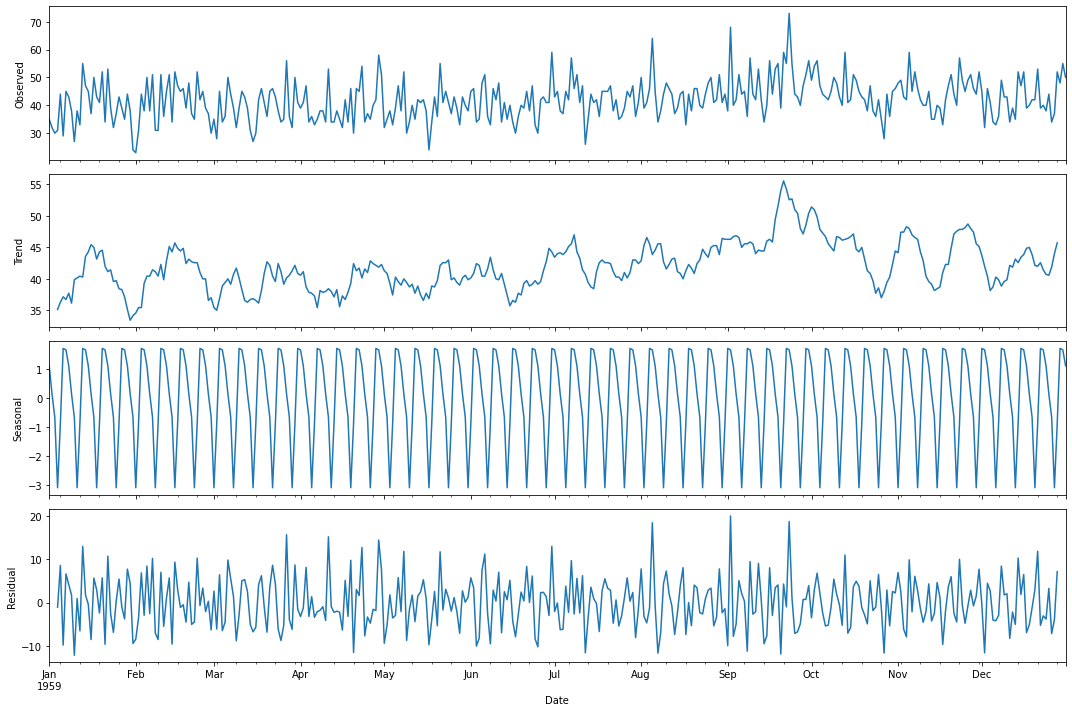

In [87]:
# evaluate components of time-series
# evaluate Dickey-Fuller test for time-series stationarity

plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(series.Births).plot()

In [88]:
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(series.Births)[1])

Dickey-Fuller test: p=0.000052


it's a stationary series

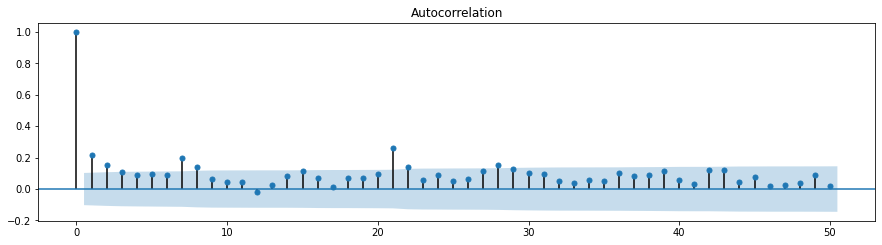

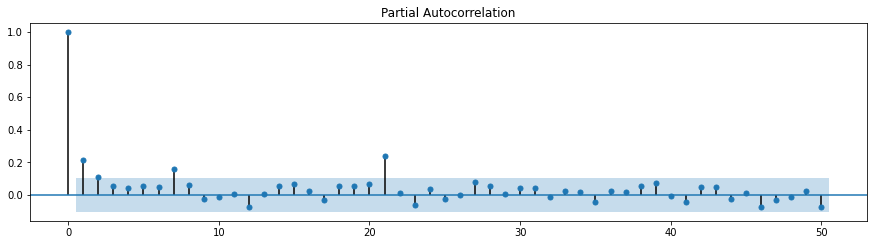

In [89]:
# let's calculate autocorrelation and partial autocorrelation components

plt.figure(figsize(15,8))

# autocorrelation 
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(series.Births.values.squeeze(), lags=50, ax=ax)
pylab.show()

# partial autocorrelation 
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(series.Births.values.squeeze(), lags=50, ax=ax)
pylab.show()

In [90]:
# parameters for SARIMA model

ps = range(0, 6)
d=1
qs = range(0, 6)
Ps = range(0, 2)
D=1
Qs= range(0,1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print ("Number of analysed models:", len(parameters_list))

Number of analysed models: 72


In [91]:
%%time
results = []
best_aic = float("inf")

# ignore warnings 
warnings.filterwarnings('ignore')

for param in parameters_list:
    
    #try except for the case of wrong parameters
    try:
        model=sm.tsa.statespace.SARIMAX(series.Births, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        
    #print wrong parameters and go on
    # AIC criteria: 
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    #print(aic)

    # save best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
        results.append([param, model.aic])
        #print(results)
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())     

def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda*y + 1)/lmbda)

      parameters          aic
13  (4, 4, 1, 0)  2513.811784
12  (3, 5, 1, 0)  2514.788181
11  (3, 4, 1, 0)  2515.109504
10  (3, 3, 1, 0)  2517.034164
9   (2, 3, 1, 0)  2521.120983
CPU times: user 3min 48s, sys: 2min 57s, total: 6min 45s
Wall time: 3min 26s


In [92]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
13  (4, 4, 1, 0)  2513.811784
12  (3, 5, 1, 0)  2514.788181
11  (3, 4, 1, 0)  2515.109504
10  (3, 3, 1, 0)  2517.034164
9   (2, 3, 1, 0)  2521.120983


In [93]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             Births   No. Observations:                  365
Model:             SARIMAX(4, 1, 4)x(1, 1, 0, 12)   Log Likelihood               -1246.906
Date:                            Sat, 25 Dec 2021   AIC                           2513.812
Time:                                    08:33:02   BIC                           2552.448
Sample:                                01-01-1959   HQIC                          2529.187
                                     - 12-31-1959                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7752      0.058    -30.580      0.000      -1.889      -1.661
ar.L2         -1.5010      0.117   

Student test: p=0.300134
Dickey-Fuller test: p=0.0000000000000000000000000


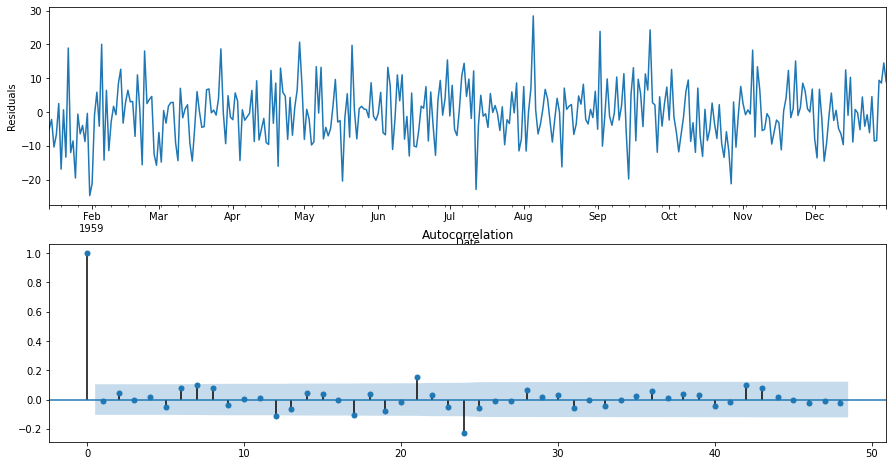

In [94]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Student test: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Dickey-Fuller test: p=%.25f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Student test: p=0.300134
Dickey-Fuller test: p=0.0000000000000000000000000


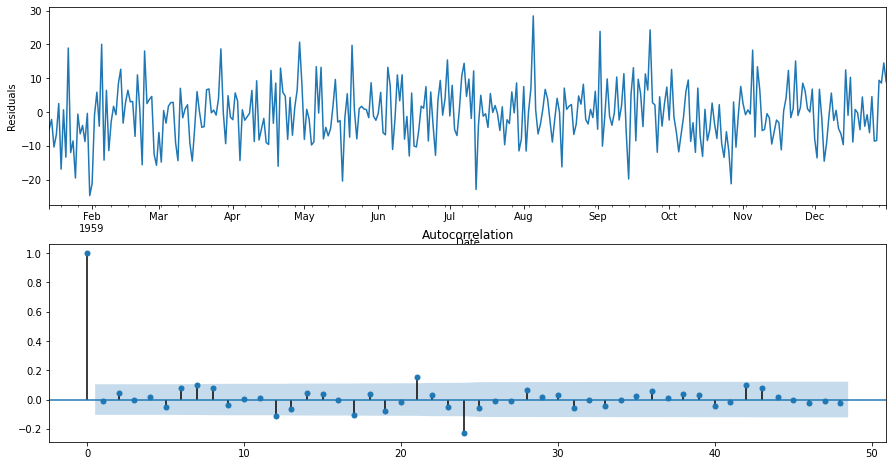

In [95]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Student test: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Dickey-Fuller test: p=%.25f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

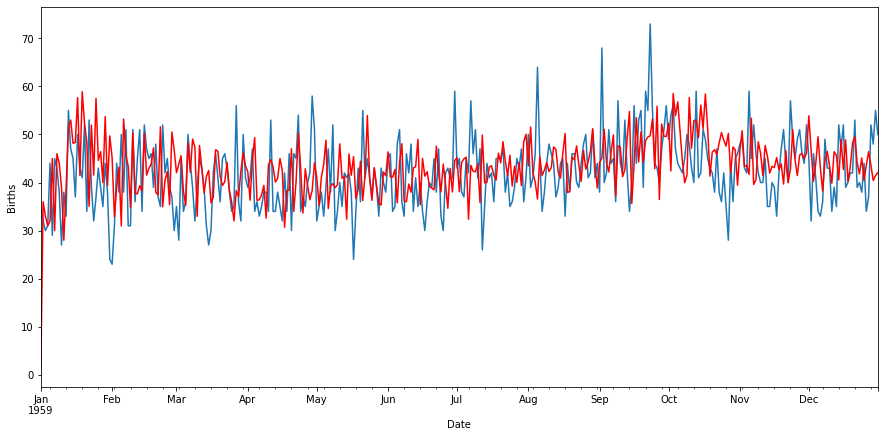

In [101]:
#inverse Box-Cox transformation:

def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda*y + 1)/lmbda)
    
series['model'] = invboxcox(best_model.fittedvalues, 1)
plt.figure(figsize(15,7))
series.Births.plot()
series.model.plot(color='r')
plt.ylabel('Births')
pylab.show()


In [139]:
series.head()

,Births,model
Date,,
1959-01-01,35,1.000000
1959-01-02,32,35.998584
1959-01-03,30,33.000156
1959-01-04,31,31.000030
1959-01-05,44,31.999892


### Evaluation Metrics

In [103]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score

R2 = r2_score(series['Births'][int((4/5)*len(series)):], series['model'][int((4/5)*len(series)):])
MAPE = mean_absolute_percentage_error(series['Births'][int((4/5)*len(series)):], 
                                      series['model'][int((4/5)*len(series)):])
print('MAPE:{} \n R2 score:{}'.format(MAPE, R2))


MAPE:0.15790362639414815 
 R2 score:-0.5533907837262331


In [129]:

_, lmbda = stats.boxcox(series.Births)

### Forecasting next 300 days....

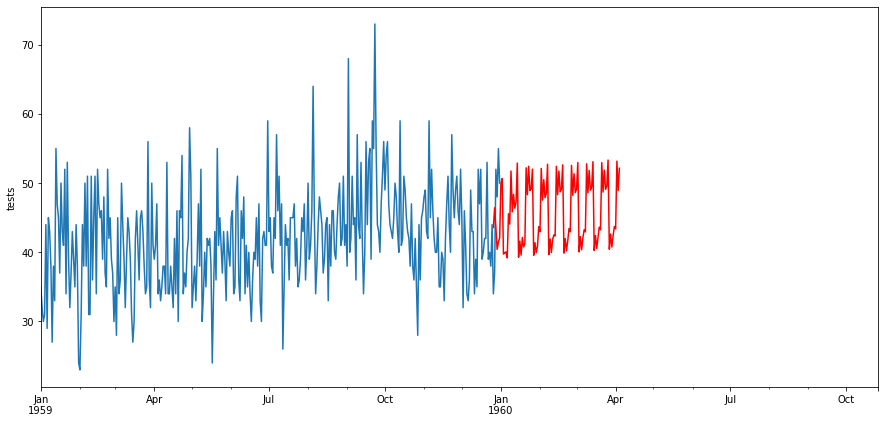

In [145]:
data2 = series[['Births']]
date_list = [datetime.datetime.strptime("1960-01-01", "%Y-%m-%d") + relativedelta(days=x) for x in range(0,300)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=359, end=459), 1)

plt.figure(figsize(15,7))
data2['Births'].plot()
data2.forecast.plot(color='r')
plt.ylabel('tests')
pylab.show()

## Conclusion

LSTM model works better as compared to ARIMA model as tested on the unknown data. 